In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud,STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from keras.preprocessing.text import Tokenizer
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Tweet= pd.read_csv("../input/Tweets.csv")
Tweet.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_st

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
Tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


We can see there's 14650 rows and 15 columns of data. There's a lot of missing data within some of these columns and there's a lot of information here we don't need so let's reduce the dataframe to the columns of interest, and rename them and set the dates as the index.

In [4]:
Tweet = Tweet.loc[: , ['airline_sentiment', 
                         'airline_sentiment_confidence',
                         'negativereason',
                         'negativereason_confidence',              
                         'name',
                         'text',
                         'tweet_coord',
                         'tweet_created',
                         'airline']]
Tweet = Tweet.set_index('tweet_created')
Tweet.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,text,tweet_coord,airline
tweet_created,,,,,,,,
2015-02-24 11:35:52 -0800,neutral,1.0000,NaN,NaN,cairdin,@VirginAmerica What @dhepburn said.,NaN,Virgin America
2015-02-24 11:15:59 -0800,positive,0.3486,NaN,0.0000,jnardino,@VirginAmerica plus you've added commercials t...,NaN,Virgin America
2015-02-24 11:15:48 -0800,neutral,0.6837,NaN,NaN,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,Virgin America
2015-02-24 11:15:36 -0800,negative,1.0000,Bad Flight,0.7033,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,Virgin America
2015-02-24 11:14:45 -0800,negative,1.0000,Can't Tell,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,Virgin America


In [5]:
Tweet.describe()

,airline_sentiment_confidence,negativereason_confidence
count,14640.000000,10522.000000
mean,0.900169,0.638298
std,0.162830,0.330440
min,0.335000,0.000000
25%,0.692300,0.360600
50%,1.000000,0.670600
75%,1.000000,1.000000
max,1.000000,1.000000


Let's inspect the airlines by grouping the data by airlines and indexing each of their ratings

In [6]:
Tweet.groupby('airline')['airline_sentiment'].count()

airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: airline_sentiment, dtype: int64

Lets regroup our dataframe and extract the lower level details of each airlines ratings.

In [7]:
Tweet.groupby(['airline','airline_sentiment']).count().iloc[:,0]

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: airline_sentiment_confidence, dtype: int64

let's create a graph by plots the total number of each tweet rating (positive,negative, or neutral)

Text(0, 0.5, 'Ratings Count')

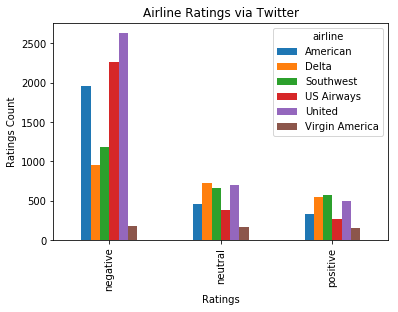

In [8]:
ax = Tweet.groupby(['airline','airline_sentiment']).count().iloc[:,0].unstack(0).plot(kind = 'bar', title = 'Airline Ratings via Twitter')
ax.set_xlabel('Ratings')
ax.set_ylabel('Ratings Count')

Let's explore what percentage of negative, neutral and positive tweets to the total tweets for each airline.

In [9]:
def percentages(df, rating = 'negative'):
    if rating == 'negative':
        i = 0
        column = 'Percent Negative Ratings'
    elif rating == 'neutral':
        i = 1
        column = 'Percent Neutral Ratings'
    elif rating == 'positive':
        i = 2
        column = 'Percent Positive Ratings'
        
    #Count of all tweet ratings for each airline (negative, neutral, positive)
    each_airline_ratings_counts = df.groupby(['airline','airline_sentiment']).count().iloc[:,0]
    #Rating tweet total index for each airline:
    #American i
    #Delta i + 3
    #southwest i + 6
    #US Airways i + 9
    #United i + 12
    #Virgin i + 15

    #Count of total tweets about an airline
    total_airline_ratings_counts = df.groupby(['airline'])['airline_sentiment'].count()
    #Airline index in total tweets:
    #American 0
    #Delta 1
    #Southwest 2
    #US Airways 3
    #United 4
    #Virgin 5


    #Create a dictionary of percentage of rating tweets = (each_airline_ratings_counts / total_airline_ratings_counts)
    tweet_ratings_dict = {'American':each_airline_ratings_counts[i] / total_airline_ratings_counts[0],
                'Delta':each_airline_ratings_counts[i + 3] / total_airline_ratings_counts[1],
                'Southwest': each_airline_ratings_counts[i + 6] / total_airline_ratings_counts[2],
                'US Airways': each_airline_ratings_counts[i + 9] / total_airline_ratings_counts[3],
                'United': each_airline_ratings_counts[i + 12] / total_airline_ratings_counts[4],
                'Virgin': each_airline_ratings_counts[i + 15] / total_airline_ratings_counts[5]}

    #make a dataframe from the dictionary
    percent_tweet_ratings = pd.DataFrame.from_dict(tweet_ratings_dict, orient = 'index')
    
    #have to manually set column name when using .from_dict() method
    percent_tweet_ratings.columns = [column]
        
    return percent_tweet_ratings

Now let's compile our percentages and plot them.

In [10]:
#Create a df called negative that contains the percent negatives by calling the function above
percent_negative_ratings = percentages(Tweet, 'negative')

#Create a df called neutral that contains the percent neutrals by calling the function above
percent_neutral_ratings = percentages(Tweet, 'neutral')

#Create a df called positive that contains the percent positives by calling the function above
percent_positive_ratings= percentages(Tweet, 'positive')

def merging_airlines_ratings_dataframes(x,y,z):

    concatenate_airlines_ratings_dataframes = pd.concat([x,y,z], axis = 1)
    return concatenate_airlines_ratings_dataframes

#concatenate all 3 dataframes of percent ratings
percent_ratings_dataframes_concatenated = merging_airlines_ratings_dataframes(percent_neutral_ratings, percent_negative_ratings, percent_positive_ratings)
print(percent_ratings_dataframes_concatenated)

            Percent Neutral Ratings  Percent Negative Ratings  \
American                   0.167814                  0.710402   
Delta                      0.325383                  0.429793   
Southwest                  0.274380                  0.490083   
US Airways                 0.130793                  0.776862   
United                     0.182365                  0.688906   
Virgin                     0.339286                  0.359127   

            Percent Positive Ratings  
American                    0.121783  
Delta                       0.244824  
Southwest                   0.235537  
US Airways                  0.092345  
United                      0.128728  
Virgin                      0.301587  


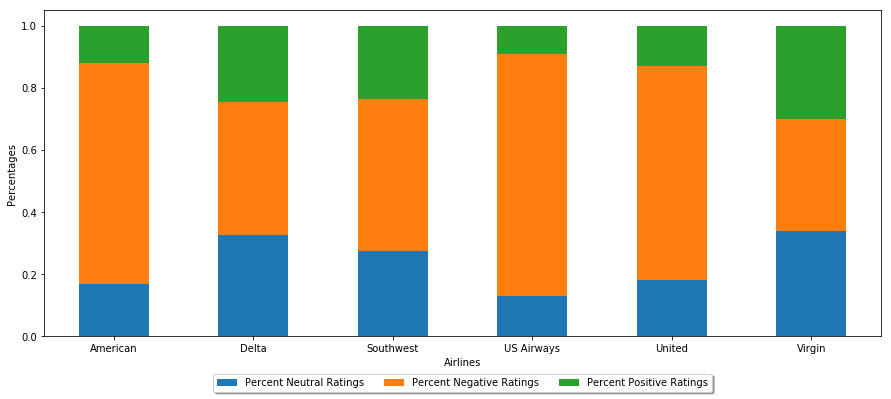

In [11]:
#graph all of airlines ratings dataframes
ax = percent_ratings_dataframes_concatenated.plot(kind = 'bar', stacked = True, rot = 0, figsize = (15,6))
#set x label
ax.set_xlabel('Airlines')
#set y label
ax.set_ylabel('Percentages')
#move the legend to the bottom of the graph
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

plt.show()

As the below code shown when we explored those particular locations in the airline column and tweet text column we found that Delta was tagged as the Airline being referenced in the tweet. But when we look at the actual text we can see it was really Jet Blue being referenced . 

In [12]:
airline_column = list(Tweet.reset_index().iloc[6750:6755,8])
tweet_text_column = list(Tweet.reset_index().iloc[6750:6755,6])

for pos, item in enumerate(airline_column):
    print('Airline as entered: ' + str(item))
    print('The tweet text: ')
    print(tweet_text_column[pos], '\n''\n')

Airline as entered: Delta
The tweet text: 
@JetBlue everyone is here but our pilots are no where to be found and my last flight the plane was dirty that I had to clean my area &amp; seat! 


Airline as entered: Delta
The tweet text: 
@JetBlue update on Flight 462 would be appreciated when you have time, thanks 


Airline as entered: Delta
The tweet text: 
@JetBlue check DM please :) 


Airline as entered: Delta
The tweet text: 
@JetBlue Hey guys, why did my last flight earn me 0 pts? http://t.co/1syWlmTZek 


Airline as entered: Delta
The tweet text: 
@JetBlue 2 aisles of empty #evermoreroom seats and we can't move bc we didn't pay?! #nonsense #Waste #JetBlue #jetbluebos #cheap 




We now must get rid of the 'Airline' column in the dataframe, parse all the tweet text and pullout the proper airline being referenced in all Tweets

In [13]:
Tweet = Tweet.iloc[:,0:6]
Tweet.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,text
tweet_created,,,,,,
2015-02-24 11:35:52 -0800,neutral,1.0000,NaN,NaN,cairdin,@VirginAmerica What @dhepburn said.
2015-02-24 11:15:59 -0800,positive,0.3486,NaN,0.0000,jnardino,@VirginAmerica plus you've added commercials t...
2015-02-24 11:15:48 -0800,neutral,0.6837,NaN,NaN,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...
2015-02-24 11:15:36 -0800,negative,1.0000,Bad Flight,0.7033,jnardino,@VirginAmerica it's really aggressive to blast...
2015-02-24 11:14:45 -0800,negative,1.0000,Can't Tell,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...


parse all the tweet text and pullout the proper airline being referenced in all Tweets

In [14]:
import re


# We create new column called 'Airline'Then we extract the right airline from the tweet text by applying regular expression function to the 'text' column
Tweet['Airline'] = Tweet.text.apply(lambda x: re.findall('\@\w+', x)[0])

#get all unique twitter tags and the count for how many times it appears in the column
twitter_text_tags = np.unique(Tweet.Airline, return_counts = True)

#compile twitter_text_tags so that it lists the unique tag and its total count side by side instead of 2 seperate arrays
twitter_tags_count = list(zip(twitter_text_tags[0],twitter_text_tags[1]))
twitter_tags_count

[('@AlbertBreer', 1),
 ('@AmericanAir', 2722),
 ('@AndrewFallis', 1),
 ('@CatfoodBeerGlue', 1),
 ('@DadBoner', 1),
 ('@DeltaAssist', 2),
 ('@HillAConlin', 1),
 ('@Imaginedragons', 1),
 ('@InternJohnRadio', 1),
 ('@JetBlue', 2167),
 ('@Jetblue', 4),
 ('@KCIAirport', 1),
 ('@MandarinJourney', 1),
 ('@MelissaAFrancis', 1),
 ('@NinaDavuluri', 1),
 ('@Sb5551', 1),
 ('@SouthwestAir', 2370),
 ('@Southwestair', 2),
 ('@USAIRWAYS', 1),
 ('@USAirways', 2817),
 ('@USairways', 2),
 ('@United', 122),
 ('@UsAirways', 2),
 ('@Usairways', 2),
 ('@VirginAmerica', 486),
 ('@americanair', 32),
 ('@chasefoster', 1),
 ('@djevolutionhd', 1),
 ('@eatgregeat', 1),
 ('@jetblue', 44),
 ('@lindaSWC', 1),
 ('@malhoit', 1),
 ('@nrhodes85', 2),
 ('@nytimes', 1),
 ('@ods1819', 1),
 ('@sarahpompei', 1),
 ('@scm1133', 1),
 ('@shannonwoodward', 1),
 ('@southwestAir', 1),
 ('@southwestair', 44),
 ('@timbennettg3', 1),
 ('@united', 3695),
 ('@usairways', 81),
 ('@vanessaannz', 1),
 ('@virginAmerica', 1),
 ('@virginameric

we will compile all the airlines referenced into a list then we need to refine our regular expression search, looking not only for the airlines, but ignoring the camel case so that all spellings of an airline are equal

In [15]:
airline_companies_list = ['@virginamerica','@united','@southwestair','@americanair','@jetblue','@usairways']
    
# We compile a regex search to seperate out only the airline tag and ignoring other users tags in the text
# We are ignoring case, or capitaliztion  in order to negate all the uniquess we encountered in the list above
airlines = re.compile('|'.join(airline_companies_list), re.IGNORECASE)
    
#We apply the compiled regex search and remove the twitter tag '@'
#for example, the following code takes @AmericanAir and returns AmericanAir
Tweet['Airline'] = Tweet.Airline.apply(lambda x: np.squeeze(re.findall(airlines, x))).str.split('@').str[1]
print(list(Tweet.Airline.head(10)))

['VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'virginamerica', 'VirginAmerica']


 We will filter the data frame and find the index locations of those tweets where the airline didn't come first but came a users name instead then we display all '@' tags that was referenced in the tweet text.

In [16]:
Tweet_df_without_airline_first = Tweet.reset_index()
Tweet_df_rows_without_airline_first = Tweet_df_without_airline_first[Tweet_df_without_airline_first.Airline.isnull()].text.apply(lambda x: re.findall('\@\w+', x))
Tweet_df_rows_without_airline_first

737                              [@lindaSWC, @united]
868                       [@MandarinJourney, @united]
1088                      [@MelissaAFrancis, @United]
4013                             [@DadBoner, @united]
4604                 [@Imaginedragons, @SouthwestAir]
5614                     [@KCIAirport, @SouthwestAir]
6136     [@InternJohnRadio, @mrerickv, @SouthwestAir]
6362                    [@HillAConlin, @SouthwestAir]
6796                     [@CatfoodBeerGlue, @JetBlue]
6811                          [@eatgregeat, @JetBlue]
6906                             [@nytimes, @JetBlue]
7330                               [@shannonwoodward]
8215                                  [@NinaDavuluri]
10243                           [@Sb5551, @USAirways]
10517                     [@timbennettg3, @USAirways]
10799                        [@nrhodes85, @USAirways]
10864                      [@sarahpompei, @USAirways]
10874                     [@AndrewFallis, @USAirways]
10876                       

we find those locations that did not have an airline in place, and manually set the values for these locations in the dataframe

In [17]:
#reset the index of our dataframe
Tweet = Tweet.reset_index()

#compile a list of index locations of the tweets that return null and set their airline value to the appropriate
#airline referenced in the tweet
united = [737,868,1088,4013]
southwest = [4604,5614,5615,6136,6362]
jetblue = [6796,6811,6906]
usairways = [7330, 8215,10243,10517,10799,10864,10874,10876,11430]
american = [11159,12222,12417,12585,13491,13979]
delta = [12038, 12039]
Tweet.set_value(united,'Airline','united')
Tweet.set_value(southwest,'Airline','southwestair')
Tweet.set_value(jetblue,'Airline','jetblue')
Tweet.set_value(usairways,'Airline','usairways')
Tweet.set_value(american,'Airline','americanair')
Tweet.set_value(delta,'Airline','delta')
    
#Since all airlines tweets are camel case in different orders, make all airlines uppercase so they are all equal
Tweet.Airline = Tweet.Airline.apply(lambda x: x.upper())
    
#create a dictionary to map the all uppercase airlines to the proper naming convention
Tweet_map_airline = {'AMERICANAIR':'American Airlines',
                'JETBLUE':'Jet Blue',
                'SOUTHWESTAIR':'Southwest Airlines',
                'UNITED': 'United Airlines',
                'USAIRWAYS': 'US Airways',
                'VIRGINAMERICA':'Virgin Airlines',
                'DELTA':'Delta Airlines'}
    
#map the uppercase airlines to the proper naming convention
Tweet.Airline = Tweet.Airline.map(Tweet_map_airline)

#display our new airlines!!!
np.unique(Tweet.Airline)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please us

array(['American Airlines', 'Delta Airlines', 'Jet Blue',
       'Southwest Airlines', 'US Airways', 'United Airlines',
       'Virgin Airlines'], dtype=object)

Let's filter our data down to those ratings that have only greater than 0.51 rating confidence percentages.let's convert the date and time to be just date and convert it's type from **'string'** to be as pandas **'datetime'**.

In [18]:
Tweet_conf_df = Tweet[Tweet.airline_sentiment_confidence >= 0.51 ]
#create a copy of our original dataframe and reset the index
date = Tweet_conf_df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
Tweet_conf_df = date
print(Tweet_conf_df.info())
Tweet_conf_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14403 entries, 0 to 14402
Data columns (total 9 columns):
index                           14403 non-null int64
tweet_created                   14403 non-null object
airline_sentiment               14403 non-null object
airline_sentiment_confidence    14403 non-null float64
negativereason                  9114 non-null object
negativereason_confidence       10285 non-null float64
name                            14403 non-null object
text                            14403 non-null object
Airline                         14403 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 1012.8+ KB
None


,index,tweet_created,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,text,Airline
0,0,2015-02-24,neutral,1.0000,NaN,NaN,cairdin,@VirginAmerica What @dhepburn said.,Virgin Airlines
1,2,2015-02-24,neutral,0.6837,NaN,NaN,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,Virgin Airlines
2,3,2015-02-24,negative,1.0000,Bad Flight,0.7033,jnardino,@VirginAmerica it's really aggressive to blast...,Virgin Airlines
3,4,2015-02-24,negative,1.0000,Can't Tell,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,Virgin Airlines
4,5,2015-02-24,negative,1.0000,Can't Tell,0.6842,jnardino,@VirginAmerica seriously would pay $30 a fligh...,Virgin Airlines
5,6,2015-02-24,positive,0.6745,NaN,0.0000,cjmcginnis,"@VirginAmerica yes, nearly every time I fly VX...",Virgin Airlines
6,7,2015-02-24,neutral,0.6340,NaN,NaN,pilot,@VirginAmerica Really missed a prime opportuni...,Virgin Airlines
7,8,2015-02-24,positive,0.6559,NaN,NaN,dhepburn,"@virginamerica Well, I didn't…but NOW I DO! :-D",Virgin Airlines
8,9,2015-02-24,positive,1.0000,NaN,NaN,YupitsTate,"@VirginAmerica it was amazing, and arrived an ...",Virgin Airlines
9,10,2015-02-24,neutral,0.6769,NaN,0.0000,idk_but_youtube,@VirginAmerica did you know that suicide is th...,Virgin Airlines


Let's explore again the ratings types of airline(negative, neutral, positive)

In [19]:
tweet_df_test = Tweet_conf_df.groupby(['Airline','airline_sentiment']).count().iloc[:,0]
tweet_df_test

Airline             airline_sentiment
American Airlines   negative             1955
                    neutral               448
                    positive              330
Delta Airlines      negative                2
Jet Blue            negative              936
                    neutral               699
                    positive              530
Southwest Airlines  negative             1177
                    neutral               641
                    positive              555
US Airways          negative             2253
                    neutral               367
                    positive              257
United Airlines     negative             2612
                    neutral               675
                    positive              472
Virgin Airlines     negative              179
                    neutral               167
                    positive              148
Name: index, dtype: int64

Let's explore again  what percentage of negative, neutral and positive tweets to the total tweets for each airline.

In [20]:
def percentages(df, rating = 'negative'):
    if rating == 'negative':
        i = 0
        column = 'Percent Negative Ratings'
    elif rating == 'neutral':
        i = 1
        column = 'Percent Neutral Ratings'
    elif rating == 'positive':
        i = 2
        column = 'Percent Positive Ratings'
        
    #Count of all tweet ratings for each airline (negative, neutral, positive), remove Delta since it only has 2 entries total
    each_airline_ratings_counts = df[df.Airline != 'Delta Airlines'].groupby(['Airline','airline_sentiment']).count().iloc[:,0]
    #Rating tweet total index for each airline:
    #American i
    #Jet Blue i + 3
    #southwest i + 6
    #US Airways i + 9
    #United i + 12
    #Virgin i + 15

    #Count of total tweets about an airline
    total_airline_ratings_counts = df[df.Airline != 'Delta Airlines'].groupby(['Airline'])['airline_sentiment'].count()
    #Airline index in total tweets:
    #American 0
    #Jet Blue 1
    #Southwest 2
    #US Airways 3
    #United 4
    #Virgin 5

    #Create a dictionary of percentage of rating tweets = (each_airline_ratings_counts / total_airline_ratings_counts)
    tweet_ratings_dict = {'American':each_airline_ratings_counts[i] / total_airline_ratings_counts[0],
                'Jet Blue':each_airline_ratings_counts[i + 3] / total_airline_ratings_counts[1],
                'Southwest': each_airline_ratings_counts[i + 6] / total_airline_ratings_counts[2],
                'US Airways': each_airline_ratings_counts[i + 9] / total_airline_ratings_counts[3],
                'United': each_airline_ratings_counts[i + 12] / total_airline_ratings_counts[4],
                'Virgin': each_airline_ratings_counts[i + 15] / total_airline_ratings_counts[5]}

    #make a dataframe from the dictionary
    percent_tweet_ratings = pd.DataFrame.from_dict(tweet_ratings_dict, orient = 'index')
    
    #have to manually set column name when using .from_dict() method
    percent_tweet_ratings.columns = [column]
        
    return percent_tweet_ratings

Let's compile our percentages and plot them.

In [21]:
#Create a df called negative that contains the percent negatives by calling the function above
percent_negative_ratings = percentages(Tweet_conf_df, 'negative')

#Create a df called neutral that contains the percent neutrals by calling the function above
percent_neutral_ratings = percentages(Tweet_conf_df, 'neutral')

#Create a df called positive that contains the percent positives by calling the function above
percent_positive_ratings= percentages(Tweet_conf_df, 'positive')


#concatenate all 3 dataframes of percent ratings
percent_ratings_dataframes_concatenated = merging_airlines_ratings_dataframes(percent_neutral_ratings, percent_negative_ratings, percent_positive_ratings)
print(percent_ratings_dataframes_concatenated)

            Percent Neutral Ratings  Percent Negative Ratings  \
American                   0.163922                  0.715331   
Jet Blue                   0.322864                  0.432333   
Southwest                  0.270122                  0.495997   
US Airways                 0.127563                  0.783107   
United                     0.179569                  0.694866   
Virgin                     0.338057                  0.362348   

            Percent Positive Ratings  
American                    0.120746  
Jet Blue                    0.244804  
Southwest                   0.233881  
US Airways                  0.089329  
United                      0.125565  
Virgin                      0.299595  


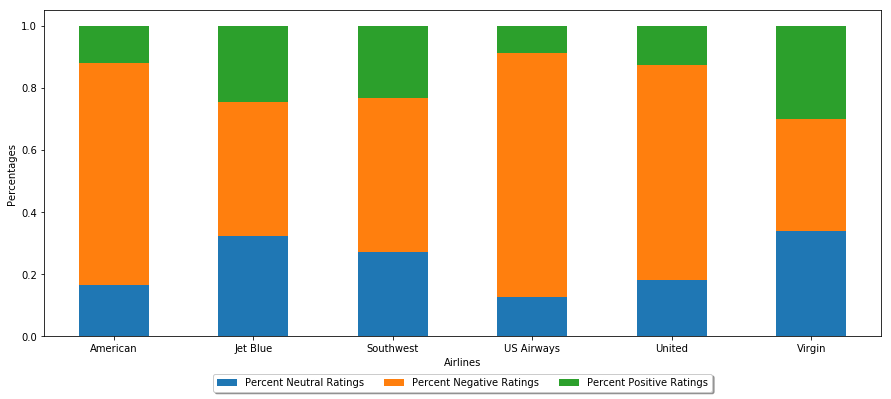

In [22]:
#graph all of airlines ratings dataframes
ax = percent_ratings_dataframes_concatenated.plot(kind = 'bar', stacked = True, rot = 0, figsize = (15,6))
#set x label
ax.set_xlabel('Airlines')
#set y label
ax.set_ylabel('Percentages')
#move the legend to the bottom of the graph
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

plt.show()

Let's extract all the negative reasons aggregate them for each airline then plotting the results.

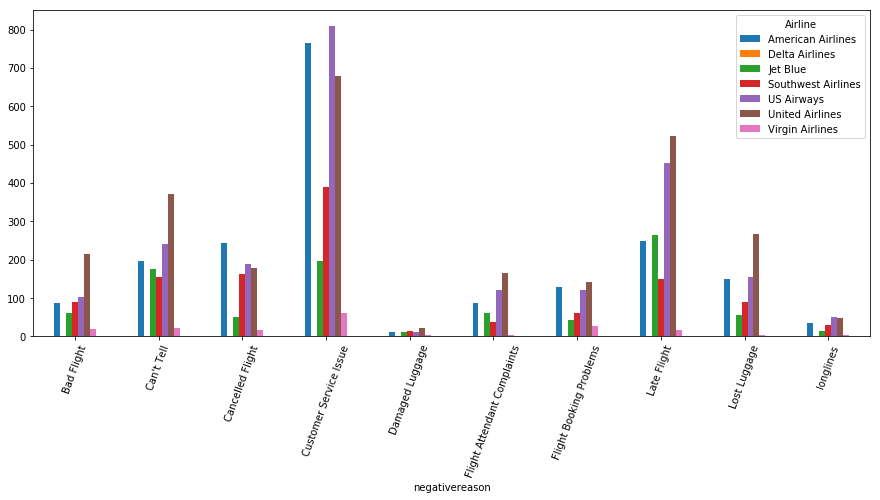

In [23]:
Tweet_conf_df_ngreason = Tweet_conf_df.reset_index().loc[:,['Airline','negativereason']].dropna().groupby(['Airline','negativereason']).size()
Tweet_conf_df_ngreason.unstack(0).plot(kind = 'bar', figsize = (15,6), rot = 70)

Let's how many of each ratings that every airline got for each date

In [24]:
Tweet_conf_day_df = Tweet_conf_df.groupby(['tweet_created','Airline','airline_sentiment']).size()
Tweet_conf_day_df

tweet_created  Airline          airline_sentiment
2015-02-16     Jet Blue         negative               1
                                neutral                1
               United Airlines  negative               2
2015-02-17     Jet Blue         negative             108
                                neutral               83
                                                    ... 
2015-02-24     United Airlines  neutral               47
                                positive              24
               Virgin Airlines  negative              10
                                neutral                6
                                positive              12
Length: 139, dtype: int64

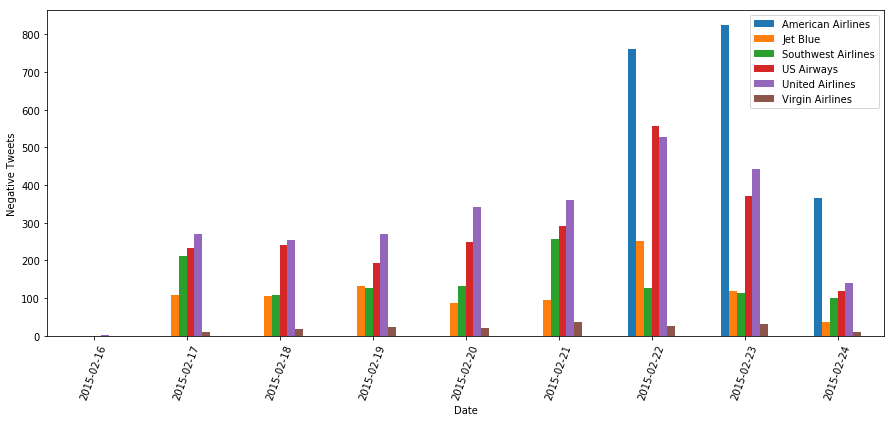

In [25]:
Tweet_conf_day_df = Tweet_conf_day_df.reset_index()
#Remove delta since it only has 2 entries
Tweet_conf_day_df = Tweet_conf_day_df[Tweet_conf_day_df.Airline != 'Delta Airlines']
#filter to only negative ratings
Tweet_conf_day_df = Tweet_conf_day_df[Tweet_conf_day_df.airline_sentiment == 'negative'].reset_index()
Tweet_conf_day_df = Tweet_conf_day_df.iloc[:,1:5]
#groupby and plot data
ax2 = Tweet_conf_day_df.groupby(['tweet_created','Airline']).sum().unstack().plot(kind = 'bar', figsize = (15,6), rot = 70)
labels = ['American Airlines','Jet Blue','Southwest Airlines','US Airways','United Airlines','Virgin Airlines']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()


Now we wiil make Word CLoud visualization for the negative ratings. the negative words with the most frequency in the data will appear with the biggest size in the wordcloud image

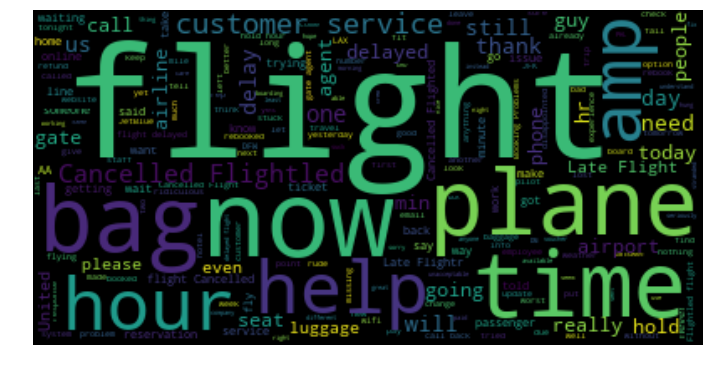

In [26]:
#We will filter the data to be the data with the negative ratings
Tweet_text_cloud_df=Tweet_conf_df[Tweet_conf_df['airline_sentiment']=='negative']
words = ' '.join(Tweet_text_cloud_df['text'])
#we will remove the links , tags and RT from the text
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
#then we will visualize the cleaned data by word cloud visualizations
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Now we wiil make Word CLoud visualization for the positive ratings. the positive words with the most frequency in the data will appear with the biggest size in the wordcloud image

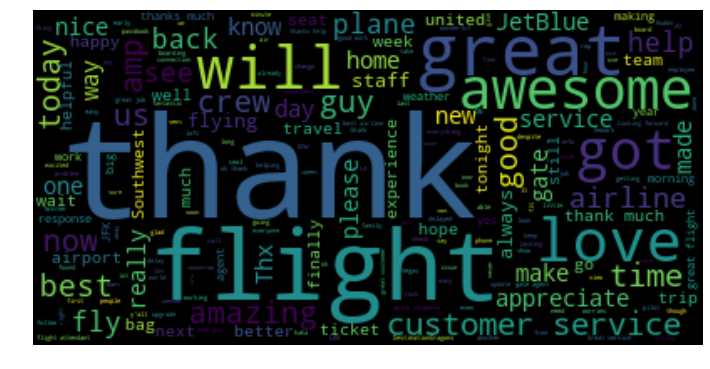

In [27]:
#We will filter the data to be the data with the positive ratings
Tweet_text_cloud_df=Tweet_conf_df[Tweet_conf_df['airline_sentiment']=='positive']
words = ' '.join(Tweet_text_cloud_df['text'])
#we will remove the links , tags and RT from the text
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
#then we will visualize the cleaned data by word cloud visualizations
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Now we wiil make Word CLoud  for the neutral ratings. the neutral words with the most frequency in the data will appear with the biggest size in the wordcloud image

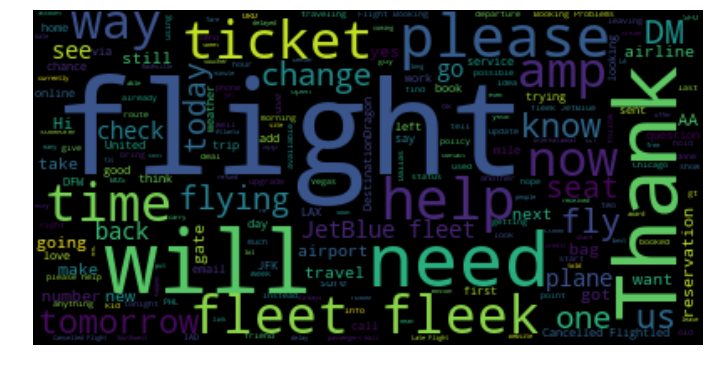

In [28]:
#We will filter the data to be the data with the neutral ratings
Tweet_text_cloud_df=Tweet_conf_df[Tweet_conf_df['airline_sentiment']=='neutral']
#we will remove the links , tags and RT from the text
words = ' '.join(Tweet_text_cloud_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
#then we will visualize the cleaned data by word cloud visualizations
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
#let's filter tweets text by applying tweet_to_words function to 'text' column 
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

Tweet_conf_df.text = Tweet_conf_df.text.apply(lambda x: tweet_to_words(x))
# We will code te values in the 'airline_sentiment' column to be numeric values
Tweet_conf_df['airline_sentiment'] = Tweet_conf_df['airline_sentiment'].replace('negative', 0)
Tweet_conf_df['airline_sentiment'] = Tweet_conf_df['airline_sentiment'].replace('neutral', 1)
Tweet_conf_df['airline_sentiment'] = Tweet_conf_df['airline_sentiment'].replace('positive', 2)



In [30]:
vect = CountVectorizer(analyzer = "word")
## Create sparse matrix from the vectorizer
dt_features= vect.fit_transform(Tweet_conf_df['text'])
text_transformed = pd.DataFrame(dt_features.toarray(), columns=vect.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(text_transformed, Tweet_conf_df['airline_sentiment'], test_size=0.2, random_state=456)
# Train a logistic regression
log_reg = LogisticRegression(C=1.0, dual=True, penalty="l2").fit(X_train, y_train)
# Predict the labels
y_predicted = log_reg.predict(X_test)

print('our score is:',  log_reg.score(X_test,y_test))
# Print accuracy score and confusion matrix on test set
print('Accuracy on the test set: ', accuracy_score(y_test, y_predicted))
print(confusion_matrix(y_test, y_predicted)/len(y_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


our score is: 0.8038875390489414
Accuracy on the test set:  0.8038875390489414
[[0.57827143 0.03852829 0.01666088]
 [0.07879209 0.11280805 0.01631378]
 [0.03054495 0.01527247 0.11280805]]


In [31]:
print(classification_report(y_predicted, y_test))

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1981
           1       0.54      0.68      0.60       480
           2       0.71      0.77      0.74       420

    accuracy                           0.80      2881
   macro avg       0.72      0.76      0.74      2881
weighted avg       0.82      0.80      0.81      2881



Let's predict the airline sentiment by **Deep learning** 

In [32]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(Tweet_conf_df.text, Tweet_conf_df.airline_sentiment, test_size=0.1, random_state=37)
tk = Tokenizer(num_words= 10000,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train_d)

X_train_seq = tk.texts_to_sequences(X_train_d)
X_test_seq = tk.texts_to_sequences(X_test_d)

def one_hot_seq(seqs, nb_features = 10000):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

le = LabelEncoder()
y_train_le = le.fit_transform(y_train_d)
y_test_le = le.transform(y_test_d)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

In [33]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, kernel_initializer = 'uniform', activation='relu', input_shape=(10000,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64,kernel_initializer = 'uniform', activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))

print(drop_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
drop_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
drop_model.fit(X_train_rest,y_train_rest, batch_size = 64, nb_epoch = 10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/10
11665/11665 [==============================] - 3s 243us/step - loss: 0.4647 - acc: 0.7821
Epoch 2/10
11665/11665 [==============================] - 2s 182us/step - loss: 0.3535 - acc: 0.8355
Epoch 3/10
11665/11665 [==============================] - 2s 184us/step - loss: 0.2733 - acc: 0.8853
Epoch 4/10
11665/11665 [==============================] - 2s 181us/step - loss: 0.2142 - acc: 0.9176
Epoch 5/10
11665/11665 [==============================] - 2s 181us/step - loss: 0.1778 - acc: 0.9329
Epoch 6/10
11665/11665 [==============================] - 2s 179us/step - loss: 0.1476 - acc: 0.9476
Epoch 7/10
11665/11665 [==============================] - 2s 180us/step - loss: 0.1233 - acc: 0.9566
Epoch 8/10
11665/11665 [==============================] - 2s 179us/step - loss: 0.1016 - acc: 0.9653
Epoch 9/10
11665/11665 [==============================] - 2s 178us/step - loss: 0.0927 - acc: 0.9677
Epoch 10/10
11665/11665 [==============================] - 2s 177us/step - loss: 0.0783 - a